In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2

## 1 Optical Flow

### 1 Horn-Schunck method

In [10]:
def drawOpticalFlow(img, u, v, scale=3, cnt=8, ax=None):
    """
    Draw optical flow on image
    :param img: image
    :param u: optical flow in x direction
    :param v: optical flow in y direction
    :return: image with optical flow drawn
    """
    ax.imshow(img)
    for i in range(0, u.shape[0], cnt):
        for j in range(0, u.shape[1], cnt):
            dx = scale * u[i, j]
            dy = scale * v[i, j]
            if (dx>0) or (dy>0):
                ax.arrow(j, i, dx, dy, color='red')
    ax.axis('off')

In [13]:
def plotFrameFlow(frame0, frame1, u, v, idx=0):
    """
    Plot optical flow between two frames
    :param frame0: first frame
    :param frame1: second frame
    :param u: optical flow in x direction
    :param v: optical flow in y direction
    """
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(frame0)
    ax[0].axis('off')
    ax[0].set_title(f'Frame {idx}')
    ax[1].imshow(frame1)
    ax[1].axis('off')
    ax[1].set_title(f'Frame {idx+1}')
    drawOpticalFlow(frame1, u, v, ax=ax[2])
    ax[2].set_title('Optical Flow')
    plt.show()


In [14]:
def hornSchunck(img1, img2, alpha=0.001, tol=0.1, num_iter=100):
    """
    Horn-Schunck Optical Flow algorithm
    :param img1: first image
    :param img2: second image
    :param alpha: smoothness parameter
    :param tol: tolerance for convergence
    :param num_iter: number of iterations
    :return: u, v - optical flow in x and y directions
    """
    # convert images to grayscale
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # convert to float32
    img1 = np.float32(img1)
    img2 = np.float32(img2)

    # noise reduction
    img1 = cv2.GaussianBlur(img1, (5, 5), 0)
    img2 = cv2.GaussianBlur(img2, (5, 5), 0)

    # compute image gradients
    kx = np.array([[-1, 1], [-1, 1]]) * 0.25
    ky = np.array([[-1, -1], [1, 1]]) * 0.25
    kt = np.array([[1, 1], [1, 1]]) * 0.25
    Ex = cv2.filter2D(img1, -1, kx) + cv2.filter2D(img2, -1, kx)
    Ey = cv2.filter2D(img1, -1, ky) + cv2.filter2D(img2, -1, ky)
    Et = cv2.filter2D(img1, -1, -kt) + cv2.filter2D(img2, -1, kt)

    # local average kernel
    kAvg = np.array([[1/12, 1/6, 1/12], [1/6, 0, 1/6], [1/12, 1/6, 1/12]])

    # initialize u and v
    u = np.zeros_like(img1)
    v = np.zeros_like(img1)

    # iterate
    iter = 0
    while iter < num_iter:
        # compute local averages
        avg_u = cv2.filter2D(u, -1, kAvg)
        avg_v = cv2.filter2D(v, -1, kAvg)

        # compute flow
        num = Ex * avg_u + Ey * avg_v + Et
        denom = alpha**2 + Ex**2 + Ey**2
        u_k = u
        u = avg_u - Ex * num / denom
        v = avg_v - Ey * num / denom

        err = np.linalg.norm(u - u_k, 2)
        if err < tol:
            break

        # update iteration count
        iter += 1


    return u, v

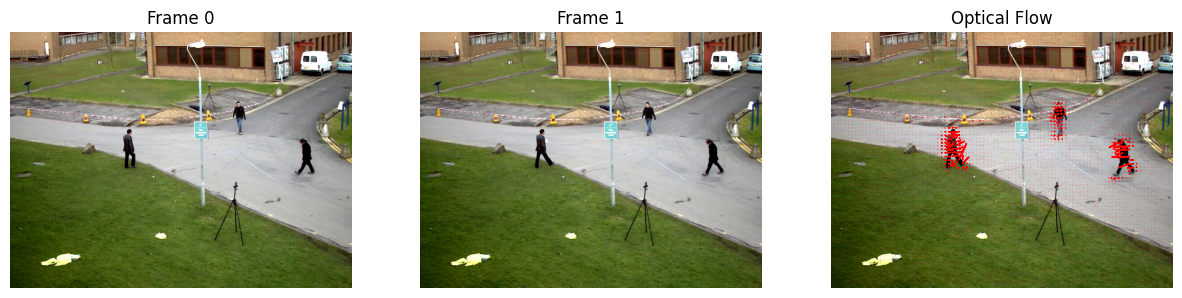

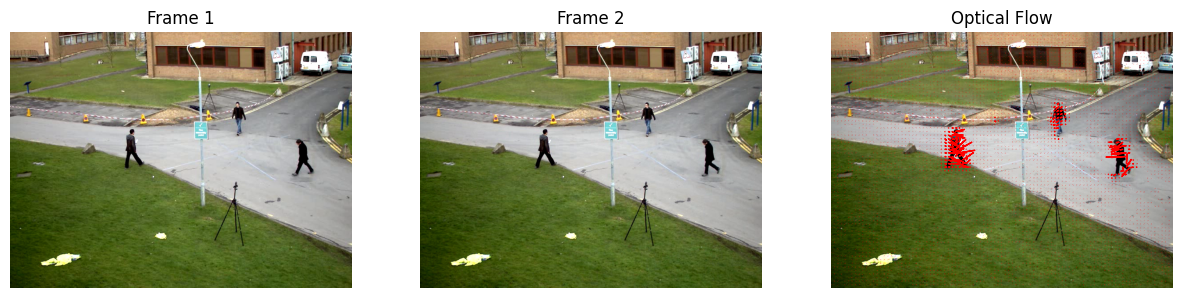

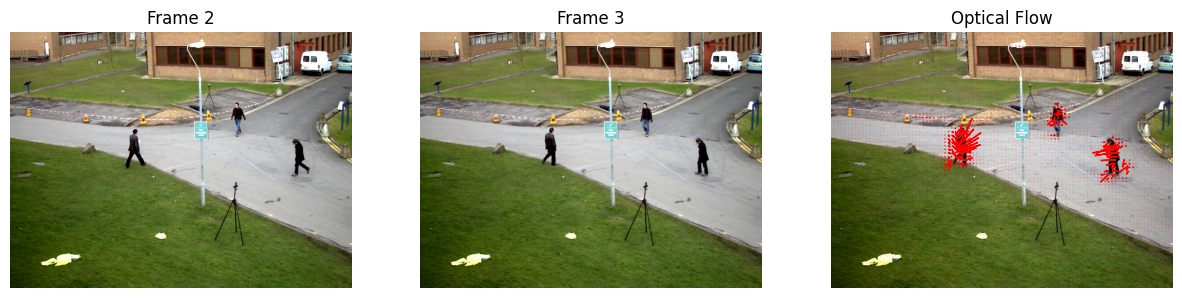

In [15]:
vidPath = 'vtest.avi'
vid = cv2.VideoCapture(vidPath)

# check if video opened successfully
if not vid.isOpened():
    print("Error opening video file")
    exit()

# store first 4 frames
frames = []
for i in range(4):
    # read frame
    ret, frame = vid.read()
    if not ret:
        print("Error reading video frame")
        break
    # convert BGR to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame_rgb)

# run Horn-Schunck on first 3 frames
u, v = hornSchunck(frames[0], frames[1], alpha=30, tol=0.001)
plotFrameFlow(frames[0], frames[1], u, v, idx=0)

u, v = hornSchunck(frames[1], frames[2], alpha=30, tol=0.001)
plotFrameFlow(frames[1], frames[2], u, v, idx=1)

u, v = hornSchunck(frames[2], frames[3], alpha=30, tol=0.001)
plotFrameFlow(frames[2], frames[3], u, v, idx=2)


### 2 Flow Former